In [1]:
import pandas as pd
import numpy as np
import requests
import json
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
# Adjust the max number of rows & cols displayed to screen
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 31)


The below cell (Python3) generates a Pandas DataFrame object, which contains all of our data (which is pulled from the data source mentioned above). We can use DataFrames to export data into CSV reports, clean and filter our data, and much more.

In [3]:
# GET json data from API using Python requests module
response = requests.get("https://api.covidtracking.com/v1/us/daily.json")
data_json = response.content

# pull json data into Pandas DataFrame, update date format & use date as index column
usa_covid_daily_df = pd.read_json(data_json)
date_format = '%Y%m%d'
usa_covid_daily_df['date'] = pd.to_datetime(usa_covid_daily_df['date'], format=date_format)
usa_covid_daily_df.set_index('date', inplace=True)

# Drop columns marked as "Deprecated" by the source.
depr_columns = ['lastModified', 'total', 'dateChecked', 'hospitalized', 'posNeg', 'hash']
usa_covid_daily_df.drop(columns=depr_columns, inplace=True)

# Delete dates where the num. states reporting < 50 (last date with < 50 states reporting was March 6, 2020)
filt = (usa_covid_daily_df['states'] < 50)
usa_covid_daily_df = usa_covid_daily_df.drop(index=usa_covid_daily_df[filt].index)

# Print to Excel with filename equal to latest date contained in dataset
# get latest date in DF
# latest_date = str(max(usa_covid_daily_df.index.values))
# filname = "csv_extracts/usa_historical/usa_covid_daily_{}.csv".format(latest_date)
# usa_covid_daily_df.to_csv('csv_extracts/usa_historical/usa_covid_daily_2020-11-11.csv')

# view df
usa_covid_daily_df.loc['2020-03'].head(5)

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,
2020-03-31,56,197569,904408,59518.0,18082.0,23725.0,3487.0,230.0,507.0,NaN,5666.0,4313.0,1143627,890,3906,87422,24840,115228
2020-03-30,56,172729,816986,65369.0,15772.0,19819.0,3087.0,187.0,451.0,NaN,4560.0,3423.0,1028399,589,2536,96077,21691,113652
2020-03-29,56,151038,720909,65545.0,14026.0,17283.0,2456.0,156.0,439.0,NaN,4052.0,2834.0,914747,515,2775,66613,19570,86396
2020-03-28,56,131468,654296,65709.0,12382.0,14508.0,2174.0,140.0,390.0,NaN,3143.0,2319.0,828351,544,2425,89725,19586,90655
2020-03-27,56,111882,564571,60091.0,10932.0,12083.0,1792.0,124.0,324.0,NaN,2418.0,1775.0,737696,406,2563,84907,19253,109364


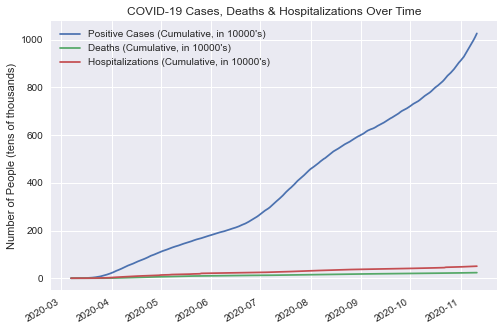

In [4]:
plt.style.use('seaborn') # define general style of chart

# pull data and reduce into 10,000's
dates = list(usa_covid_daily_df.index.values)
positive_thousands = np.array(usa_covid_daily_df['positive']) / 10000
deaths_thousands = np.array(usa_covid_daily_df['death']) / 10000
hosp_thousands = np.array(usa_covid_daily_df['hospitalizedCumulative']) / 10000

# add data to plot
plt.plot(dates, positive_thousands, label="Positive Cases (Cumulative, in 10000's)")
plt.plot(dates, deaths_thousands, label="Deaths (Cumulative, in 10000's)")
plt.plot(dates, hosp_thousands, label="Hospitalizations (Cumulative, in 10000's)")

# Format plot
plt.legend()
plt.title('COVID-19 Cases, Deaths & Hospitalizations Over Time')
plt.ylabel('Number of People (tens of thousands)')
figure = plt.gcf() # get current figure
figure.autofmt_xdate() # autoformat the figure's dates to be more readable

## Analyzing Growth

Let's start by getting the total number of positive tests, hospitalizations, and deaths per day, since March.

In [5]:
# get the number of days in the dataset
num_days = len(usa_covid_daily_df.index.values)

# get the daily rate of positive cases, hospitalizations & deaths
latest_date = max(usa_covid_daily_df.index.values)
pos_rate = int(usa_covid_daily_df.loc[latest_date]['positive'] / num_days)
hosp_rate = int(usa_covid_daily_df.loc[latest_date]['hospitalizedCumulative'] / num_days)
death_rate = int(usa_covid_daily_df.loc[latest_date]['death'] / num_days)

# now let's create a pandas Series (like a DataFrame, but one-dimensional) to display our new info.
index_vals = ['Positives per Day', 'Hospitalizations per Day', 'Deaths per Day']
data = [pos_rate, hosp_rate, death_rate] 
growth_rates = pd.Series(data=data, index=index_vals)
growth_rates

Positives per Day           41069
Hospitalizations per Day     2016
Deaths per Day                932
dtype: int64

Okay, now let's take a look at how these rates have changed over time.

We'll create a new DataFrame containing the number of new positives/hospitalizations/deaths per month.

In [6]:
# cannot apply a function to index col, so reset index temporarily
monthly_rates_df = usa_covid_daily_df.reset_index()

# add month column
get_month = lambda x: str(x.year) + '-' + str(x.month).zfill(2)
monthly_rates_df['month'] = monthly_rates_df['date'].apply(get_month)
monthly_rates_df.set_index('date', inplace=True) # reset index back to date

# Get the sum of new positives/hospitalizations/deaths for each month
month_group = monthly_rates_df.groupby(['month']) # group data by months
monthly_rates_df = month_group[["positiveIncrease", "hospitalizedIncrease", "deathIncrease"]].sum()
monthly_rates = monthly_rates_df.sort_index()

monthly_rates

,positiveIncrease,hospitalizedIncrease,deathIncrease
month,,,
2020-03,197070,23719,4287
2020-04,875465,100061,55264
2020-05,717803,86678,40918
2020-06,832777,31944,19566
2020-07,1898319,65680,25286
2020-08,1453656,62292,30265
2020-09,1189992,38269,23313
2020-10,1880652,66425,23394
2020-11,1221077,28941,10905


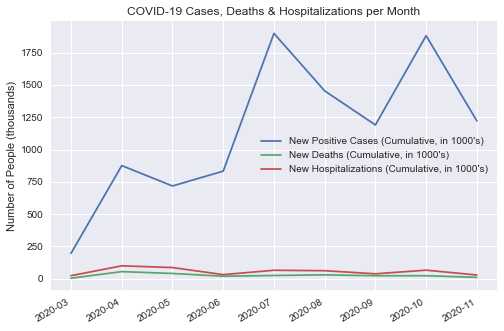

In [7]:
plt.style.use('seaborn') # define general style of chart

# pull data and reduce into 1,000's
months = list(monthly_rates.index.values)
positive_thousands = np.array(monthly_rates['positiveIncrease']) / 1000
deaths_thousands = np.array(monthly_rates['deathIncrease']) / 1000
hosp_thousands = np.array(monthly_rates['hospitalizedIncrease']) / 1000

# add data to plot
plt.plot(months, positive_thousands, label="New Positive Cases (Cumulative, in 1000's)")
plt.plot(months, deaths_thousands, label="New Deaths (Cumulative, in 1000's)")
plt.plot(months, hosp_thousands, label="New Hospitalizations (Cumulative, in 1000's)")

# Format plot
plt.legend()
plt.title('COVID-19 Cases, Deaths & Hospitalizations per Month')
plt.ylabel('Number of People (thousands)')

figure = plt.gcf() # get current figure
figure.autofmt_xdate() # autoformat the figure's dates to be more readable

<AxesSubplot:xlabel='month'>

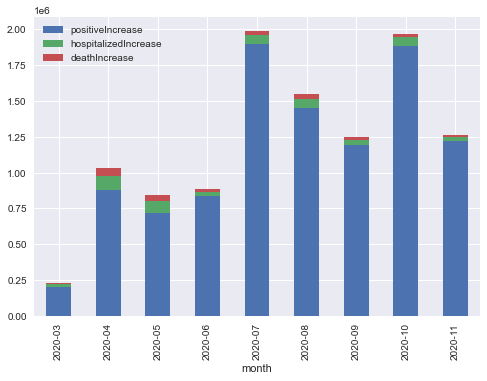

In [8]:
monthly_rates.plot.bar(stacked=True)

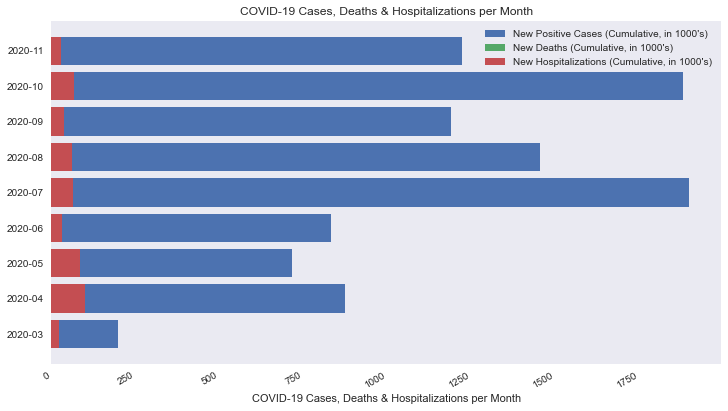

In [9]:
plt.style.use('seaborn-dark') # define general style of chart
plt.rcParams["figure.figsize"] = (12, 7) # adjust size of chart if needed

# pull data and reduce into 1,000's
months = list(monthly_rates.index.values)
positive_thousands = np.array(monthly_rates['positiveIncrease']) / 1000
deaths_thousands = np.array(monthly_rates['deathIncrease']) / 1000
hosp_thousands = np.array(monthly_rates['hospitalizedIncrease']) / 1000

# add data to plot
plt.barh(months, positive_thousands, label="New Positive Cases (Cumulative, in 1000's)")
plt.barh(months, deaths_thousands, label="New Deaths (Cumulative, in 1000's)")
plt.barh(months, hosp_thousands, label="New Hospitalizations (Cumulative, in 1000's)")

# Format plot
plt.legend()
plt.title('COVID-19 Cases, Deaths & Hospitalizations per Month')
plt.xlabel('COVID-19 Cases, Deaths & Hospitalizations per Month')

figure = plt.gcf() # get current figure
figure.autofmt_xdate() # autoformat the figure's dates to be more readable

As you can see from the above chart, the number of new deaths is too small to register on the chart. 

Instead, let's take a look at death rate vs. hospitalization rate over time (without positive tests) to get an idea of the effectiveness of treatment.

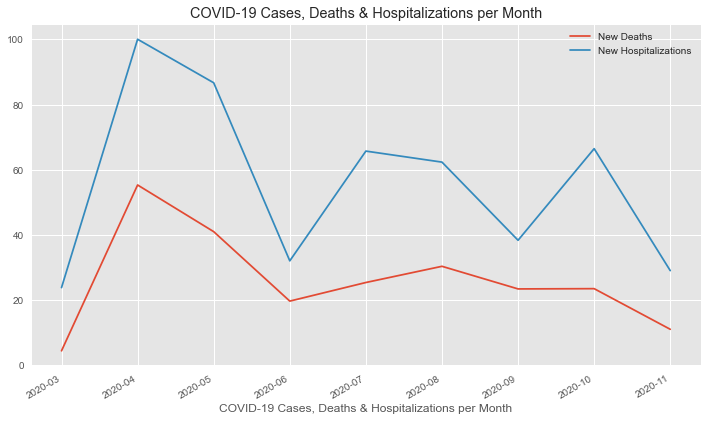

In [10]:
plt.style.use('ggplot') # define general style of chart
plt.rcParams["figure.figsize"] = (12, 7) # adjust size of chart if needed

# pull data
months = list(monthly_rates.index.values)
deaths = np.array(monthly_rates['deathIncrease'])
hosp = np.array(monthly_rates['hospitalizedIncrease'])

# add data to plot
plt.plot(months, deaths_thousands, label="New Deaths")
plt.plot(months, hosp_thousands, label="New Hospitalizations")

# Format plot
plt.legend()
plt.title('COVID-19 Cases, Deaths & Hospitalizations per Month')
plt.xlabel('COVID-19 Cases, Deaths & Hospitalizations per Month')

figure = plt.gcf() # get current figure
figure.autofmt_xdate() # autoformat the figure's dates to be more readable

**Upcoming analysis:**
- Measure effect size of new tests vs positive cases
    - determine the correlation between these two variables
    - will eventually use this to determine in which scenarios an increase in positive tests was caused by an increase in testing alone or if there were societal conditions that impacted the result
- Death Rates vs. Hospializations (non-ICU and ICU)

In [1]:
# cohen effect size function (from ThinkStats2 by Allen B. Downey)
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups.
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d